# Setup

In [3]:
import pickle as pk

import torch
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def get_cov_distance(means, covs, num_steps, source_i, target_i):
    inv_covs = torch.linalg.inv(covs)
    (source_means, source_inv) = (means[source_i], inv_covs[source_i])
    (nn_means, nn_inv) = (means[target_i], inv_covs[target_i])
    diff_vectors = nn_means - source_means[:, None]
    steps = torch.linspace(0, 1, num_steps + 1)[1:]
    interp_invs = torch.einsum("s,nlij->snlij", 1 - steps, source_inv[:, None]) + torch.einsum("s,nlij->snlij", steps, nn_inv)
    dist = torch.sqrt(torch.einsum("nli,snlij,nlj->snl", diff_vectors, interp_invs, diff_vectors)).mean(0)
    return dist

def get_euclidean_distance(means, source_i, target_i):
    diff_vectors = means[source_i, None] - means[target_i]
    dist = torch.linalg.norm(diff_vectors, dim = -1)
    return dist

# Clustering

In [5]:
with open("../../het_reg_2d_results.pkl", "rb") as target:
    data = pk.load(target)

In [8]:
section = 5.4
x_divider = 5.0
right_slice = True

left_mask = data["xy"][:, 0] < x_divider 
idx = (data["section_idx"] == section) & (right_slice ^ left_mask)
(pos, means, covs) = (data["xy"][idx], data["xy_pred"][idx], data["xy_cov_pred"][idx])
section = pd.Series(data["section_idx"][idx], dtype = "category").factorize()[0]
subclass = data["subclass"][idx].factorize()[0]
n_samples = len(pos)

In [9]:
max_clusters = 6
cov_interp_steps = 10

(X, y) = (torch.from_numpy(pos), torch.from_numpy(subclass))
cov_distances = get_cov_distance(X, torch.from_numpy(covs), cov_interp_steps, torch.arange(n_samples), torch.arange(n_samples)[None])
eucl_distances = get_euclidean_distance(X, torch.arange(n_samples), torch.arange(n_samples)[None])
results = {}
for n_clust in range(max_clusters, 1, -1):
    cov_labels = AgglomerativeClustering(metric = "precomputed", linkage = "complete", n_clusters = n_clust).fit(cov_distances).labels_
    eucl_labels = AgglomerativeClustering(metric = "precomputed", linkage = "complete", n_clusters = n_clust).fit(eucl_distances).labels_
    results[n_clust] = (eucl_labels, cov_labels)

# Plots

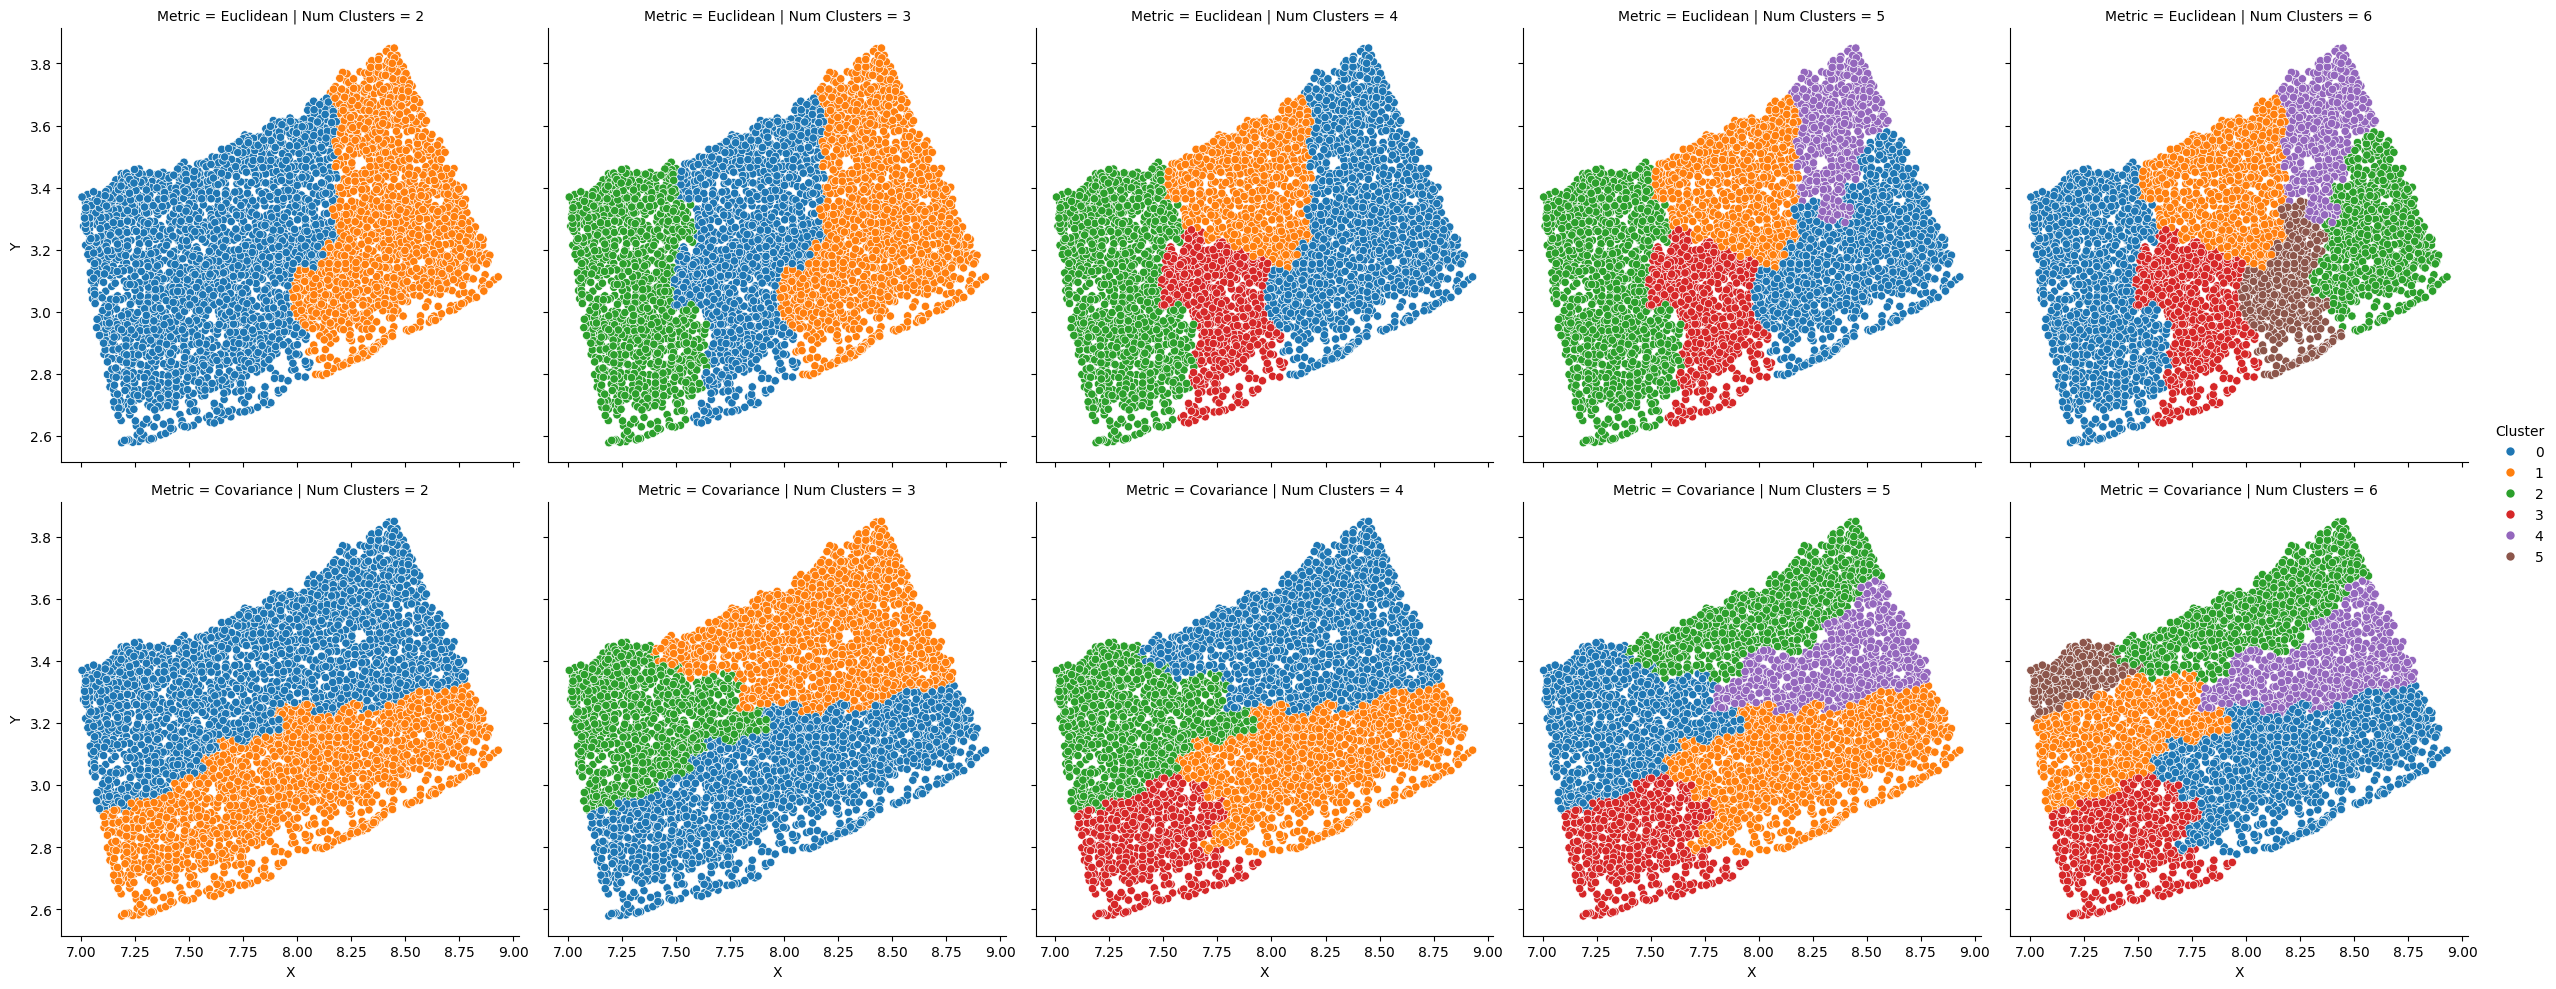

In [ ]:
sns.set_palette("tab10")
plot_data = {"X": [], "Y": [], "Num Clusters": [], "Metric": [], "Cluster": []}
for (num_clusters, metrics) in results.items():
    for (metric, clusters) in zip(["Euclidean", "Covariance"], metrics):
        plot_data["X"].extend(pos[:, 0])
        plot_data["Y"].extend(pos[:, 1])
        plot_data["Num Clusters"].extend(n_samples*[num_clusters])
        plot_data["Metric"].extend(n_samples*[metric])
        plot_data["Cluster"].extend(clusters.tolist())
plot = sns.relplot(plot_data, x = "X", y = "Y", hue = "Cluster", row = "Metric", col = "Num Clusters", palette = "tab10")
plt.show()

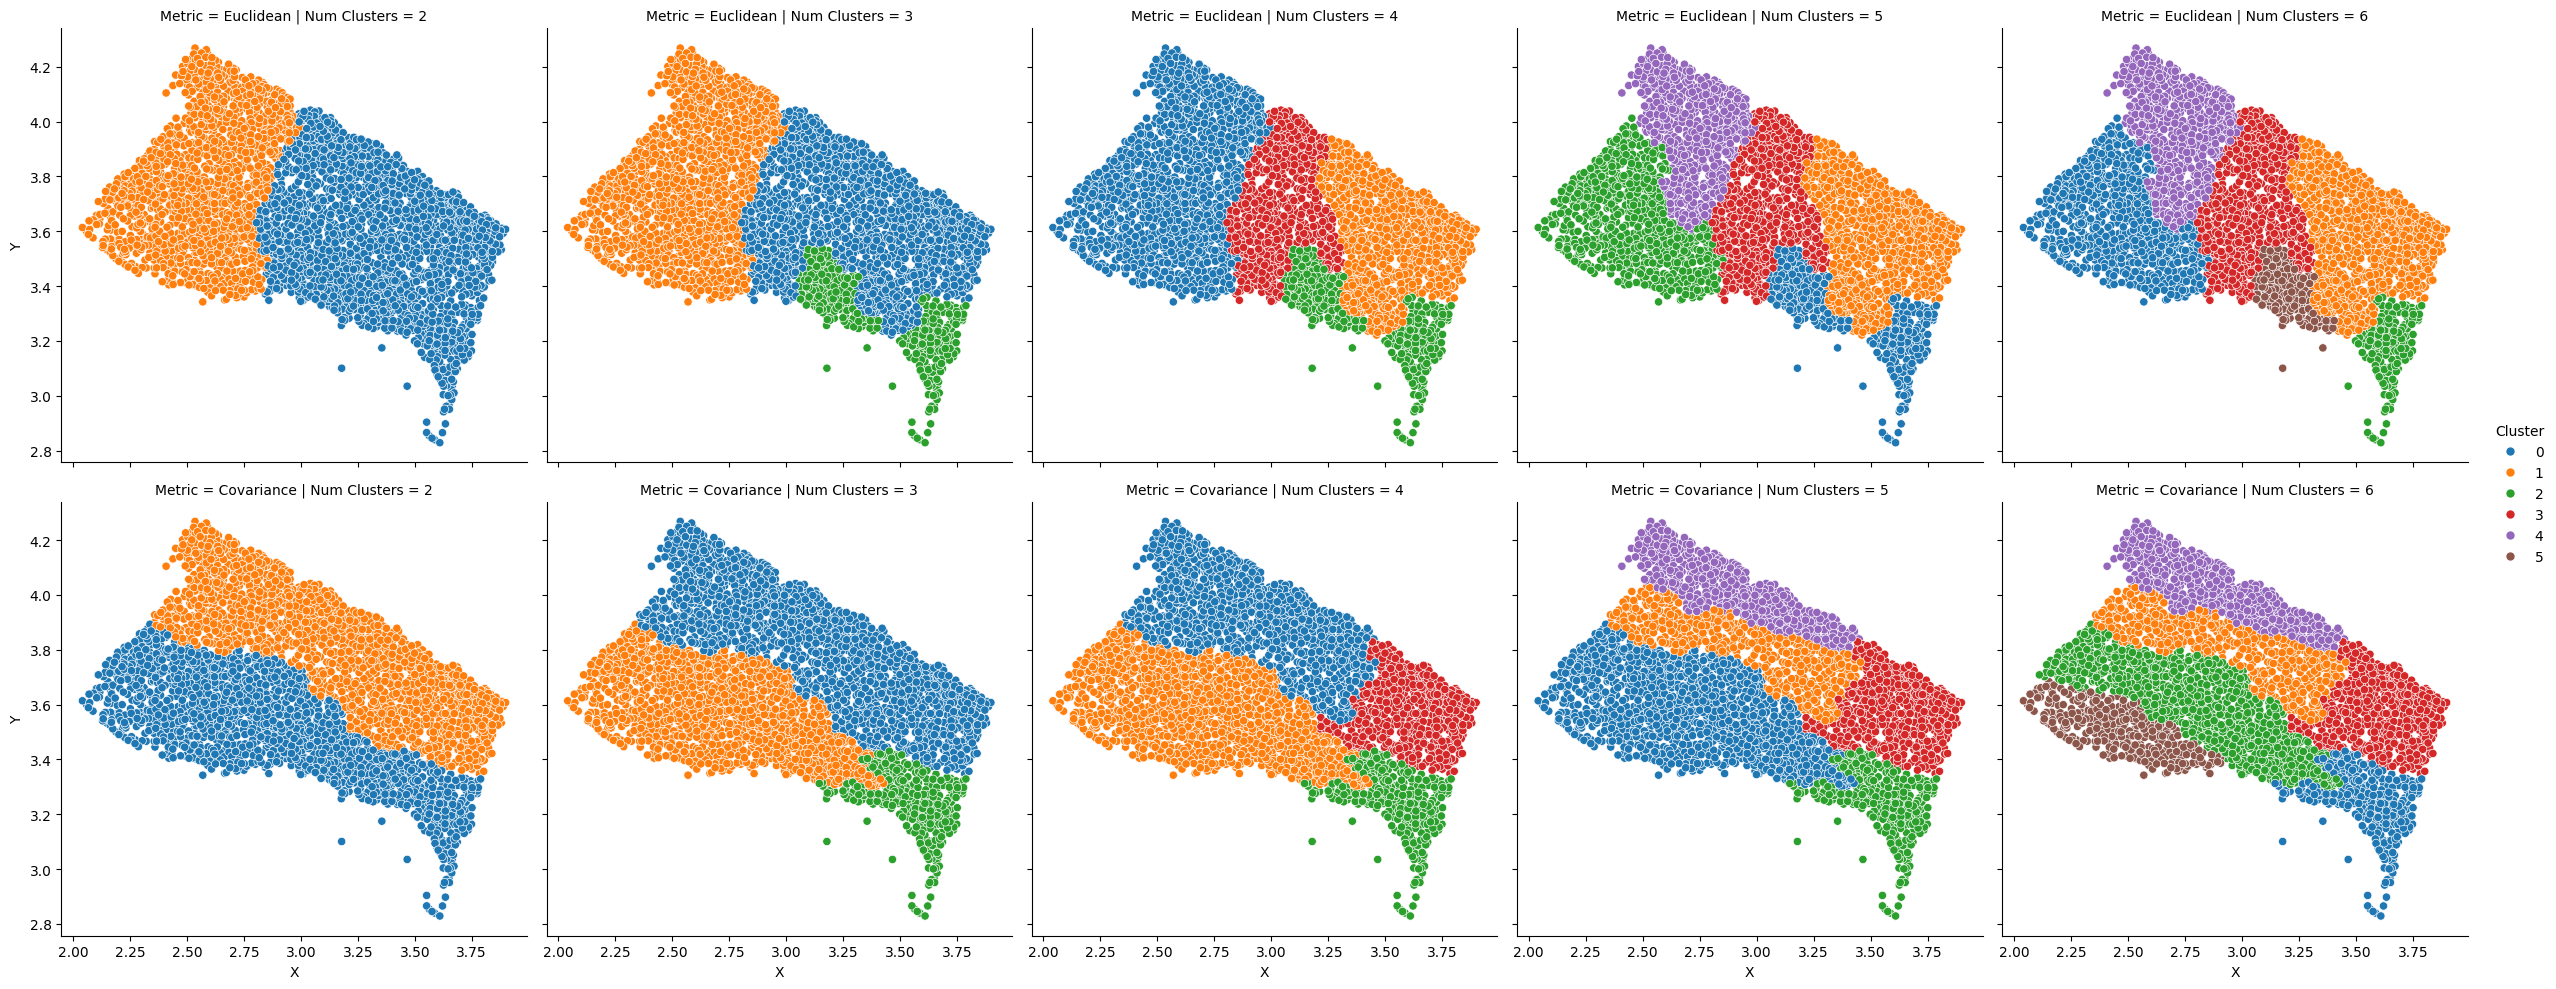

In [10]:
sns.set_palette("tab10")
plot_data = {"X": [], "Y": [], "Num Clusters": [], "Metric": [], "Cluster": []}
for (num_clusters, metrics) in results.items():
    for (metric, clusters) in zip(["Euclidean", "Covariance"], metrics):
        plot_data["X"].extend(pos[:, 0])
        plot_data["Y"].extend(pos[:, 1])
        plot_data["Num Clusters"].extend(n_samples*[num_clusters])
        plot_data["Metric"].extend(n_samples*[metric])
        plot_data["Cluster"].extend(clusters.tolist())
plot = sns.relplot(plot_data, x = "X", y = "Y", hue = "Cluster", row = "Metric", col = "Num Clusters", palette = "tab10")
plt.show()